In [1]:
import typing
import numpy as np
import pandas as pd
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 

from scipy.optimize import curve_fit
from pandas import Grouper as tg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import r2_score

$\underline{\text{Data Loading:}}$

In [2]:
# load clean data
%store -r dfSPMINI
%store -r dfUST
#dfSPMINI = pd.read_csv('dfSPMINI.csv')
#dfSPMINI = pd.read_csv('dfUST.csv')

dfSPMINI['sign'] = dfSPMINI['qty_signed'].apply(lambda x: np.sign(x))
dfUST['sign'] = dfUST['qty_signed'].apply(lambda x: np.sign(x))

In [3]:
# we store the desired data
L = 500
#SPMINI
mid_SPMINI = dfSPMINI['mid'].copy()

returns_SPMINI = dfSPMINI['returns'].copy()
returns_normalized_SPMINI = dfSPMINI['returns_normalized'].copy()

epsilons_SPMINI = dfSPMINI['sign'].copy()

#UST
mid_UST = dfUST['mid'].copy()

returns_UST = dfUST['returns'].copy()
returns_normalized_UST = dfUST['returns_normalized'].copy()

epsilons_UST = dfUST['sign'].copy()


# lengths
N_SPMINI = len(mid_SPMINI)
N_UST = len(mid_UST)

Y_SPMINI = returns_SPMINI.values[L:]
Y_UST = returns_UST.values[L:]

$\underline{\text{Learning quantities:}}$

In [4]:
max_lag = 1000
L = 500

# we define the regression matrix for each method of learning

# SPMINI
A_SPMINI = inter.regression_matrix(epsilons_SPMINI.values, L)

#UST
A_UST = inter.regression_matrix(epsilons_UST.values, L)

$\underline{\text{Learning:}}$

In [5]:
from sklearn.linear_model import LinearRegression

Res_SPMINI = inter.response_function(epsilons_SPMINI.values, mid_SPMINI.values, max_lag+1)
Res_UST = inter.response_function(epsilons_UST.values, mid_UST.values, max_lag+1)

acf_epsilons_SPMINI = inter.autocovariance(epsilons_SPMINI.values , max_lag)
acf_epsilons_UST = inter.autocovariance(epsilons_UST.values , max_lag)


reg_SPMINI = LinearRegression().fit(A_SPMINI, Y_SPMINI)
reg_UST = LinearRegression().fit(A_UST, Y_UST)

K_star_SPMINI_epsilons = reg_SPMINI.coef_
K_star_SPMINI_epsilons = pd.Series(K_star_SPMINI_epsilons)
G_star_SPMINI_epsilons = pd.concat((pd.Series([0]), K_star_SPMINI_epsilons.cumsum()))

K_star_UST_epsilons = reg_UST.coef_
K_star_UST_epsilons = pd.Series(K_star_UST_epsilons)
G_star_UST_epsilons = pd.concat((pd.Series([0]), K_star_UST_epsilons.cumsum()))

# problem inversion

S_SPMINI_epsilons = inter.sign_return_correlation2(returns_SPMINI, epsilons_SPMINI, len(Res_SPMINI))
K_approx_SPMINI_epsilons = inter.problem_inversion(S_SPMINI_epsilons, np.linalg.inv(inter.covariance_matrix(acf_epsilons_SPMINI, L)), L)
G_approx_SPMINI_epsilons = pd.concat((pd.Series([0]), K_approx_SPMINI_epsilons.cumsum()))

S_UST_epsilons = inter.sign_return_correlation2(returns_UST, epsilons_UST, len(Res_UST))
K_approx_UST_epsilons = inter.problem_inversion(S_UST_epsilons, np.linalg.inv(inter.covariance_matrix(acf_epsilons_UST, L)), L)
G_approx_UST_epsilons = pd.concat((pd.Series([0]), K_approx_UST_epsilons.cumsum()))

$\underline{\text{Results:}}$

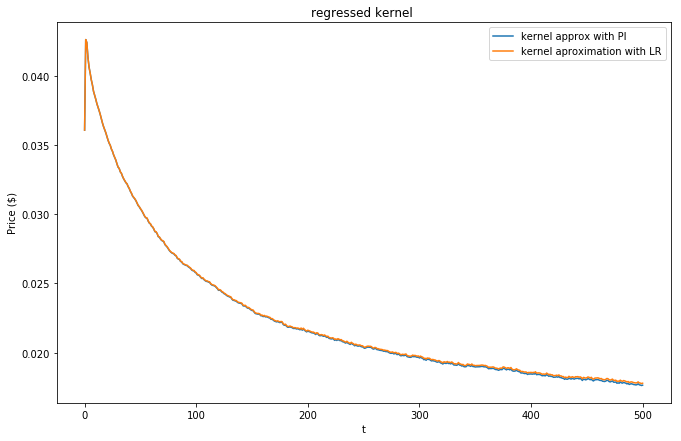

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(G_approx_SPMINI_epsilons[1:], label = 'kernel approx with PI')
ax1.plot(G_star_SPMINI_epsilons[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,500))
ax1.legend()

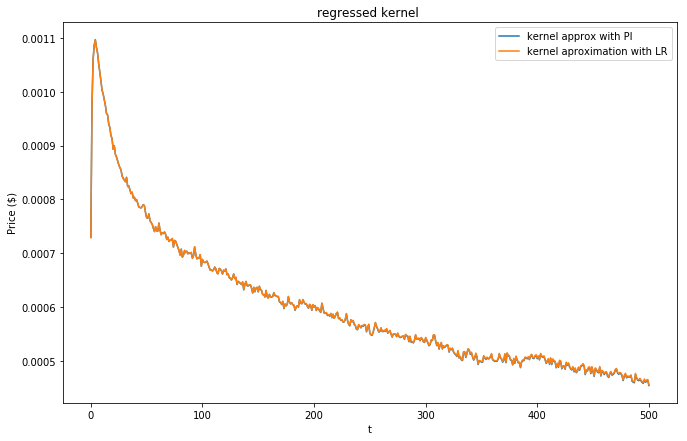

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(G_approx_UST_epsilons[1:], label = 'kernel approx with PI')
ax1.plot(G_star_UST_epsilons[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,500))
ax1.legend()

In [18]:
returns_approx_SPMINI_epsilons = reg_SPMINI.predict(A_SPMINI)
returns_approx_UST_epsilons = reg_UST.predict(A_UST)

synthetic_variogram_Gstar_SPMINI_approx_epsilons = inter.variogram(returns_approx_SPMINI_epsilons.cumsum())
synthetic_variogram_Gstar_UST_approx_epsilons = inter.variogram(returns_approx_UST_epsilons.cumsum())

variogram_SPMINI = inter.variogram(Y_SPMINI.cumsum())
variogram_UST = inter.variogram(Y_UST.cumsum())

R2_Gstar_SPMINI_approx_epsilons = inter.R2(Y_SPMINI, returns_approx_SPMINI_epsilons)
R2_Gstar_UST_approx_epsilons = inter.R2(Y_UST, returns_approx_UST_epsilons)

In [15]:
print(R2_Gstar_SPMINI_approx_epsilons)
print(R2_Gstar_UST_approx_epsilons)

0    0.144326
dtype: float64
0    0.063001
dtype: float64


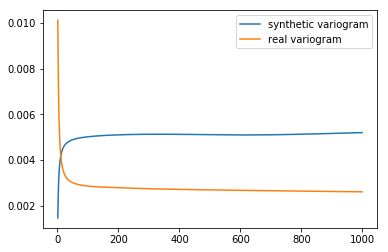

In [20]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

plt.plot(synthetic_variogram_Gstar_SPMINI_approx_epsilons[1:]/np.arange(1,len(synthetic_variogram_Gstar_SPMINI_approx_epsilons)), label = 'synthetic variogram')
plt.plot(variogram_SPMINI[1:]/np.arange(1,len(variogram_SPMINI)), label = 'real variogram')

#plt.xlim((.00,1000))
#plt.ylim((.0,.005))
plt.legend()

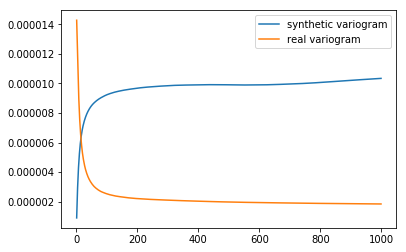

In [21]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

plt.plot(synthetic_variogram_Gstar_UST_approx_epsilons[1:]/np.arange(1,len(synthetic_variogram_Gstar_UST_approx_epsilons)), label = 'synthetic variogram')
plt.plot(variogram_UST[1:]/np.arange(1,len(variogram_UST)), label = 'real variogram')

#plt.xlim((.00,1000))
#plt.ylim((.0,.005))
plt.legend()

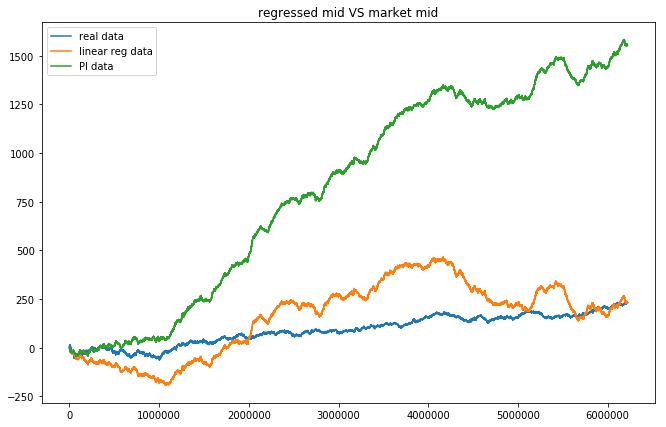

In [33]:
noise = np.random.normal(0,0, len(returns_SPMINI))
m = 10000
returns_PI_SPMINI = pd.Series(inter.generator(epsilons_SPMINI.values, G_approx_SPMINI_epsilons, noise, L-1)).loc[L-1:]
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(returns_SPMINI.cumsum(), label = 'real data')
ax1.plot( returns_approx_SPMINI_epsilons.cumsum(), label = 'linear reg data' )
ax1.plot( returns_PI_SPMINI.values.cumsum(), label = 'PI data' )
ax1.set_title('regressed mid VS market mid')
ax1.legend()


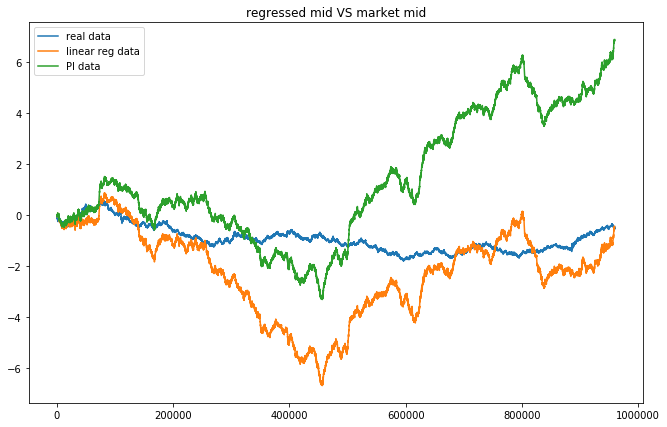

In [32]:
noise = np.random.normal(0,0, len(returns_UST))
m = 10000
returns_PI_UST = pd.Series(inter.generator(epsilons_UST.values, G_approx_UST_epsilons, noise, L-1)).loc[L-1:]
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(returns_UST.cumsum(), label = 'real data')
ax1.plot( returns_approx_UST_epsilons.cumsum(), label = 'linear reg data' )
ax1.plot( returns_PI_UST.values.cumsum(), label = 'PI data' )
ax1.set_title('regressed mid VS market mid')
ax1.legend()


$\underline{\text{Storage:}}$

In [34]:
# data to store:

# kernels
% store G_star_SPMINI_epsilons
% store G_approx_SPMINI_epsilons

% store G_star_UST_epsilons
% store G_approx_UST_epsilons

# synthetic variograms
% store synthetic_variogram_Gstar_UST_approx_epsilons
% store synthetic_variogram_Gstar_SPMINI_approx_epsilons

# R squared
% store R2_Gstar_SPMINI_approx_epsilons
% store R2_Gstar_UST_approx_epsilons

# synthetic returns
% store returns_approx_SPMINI_epsilons
% store returns_approx_UST_epsilons

Stored 'G_star_SPMINI_epsilons' (Series)
Stored 'G_approx_SPMINI_epsilons' (Series)
Stored 'G_star_UST_epsilons' (Series)
Stored 'G_approx_UST_epsilons' (Series)
Stored 'synthetic_variogram_Gstar_UST_approx_epsilons' (Series)
Stored 'synthetic_variogram_Gstar_SPMINI_approx_epsilons' (Series)
Stored 'R2_Gstar_SPMINI_approx_epsilons' (Series)
Stored 'R2_Gstar_UST_approx_epsilons' (Series)
Stored 'returns_approx_SPMINI_epsilons' (ndarray)
Stored 'returns_approx_UST_epsilons' (ndarray)
